In [1]:
library(dplyr)
library(lme4)
library(nlme)
library(purrr)
library(performance)
library(tibble)
library(MuMIn)
library(here)
library(reactablefmtr)
library(emmeans)
library(car)
library(ggplot2)
library(modelr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: ‘nlme’


The following object is masked from ‘package:lme4’:

    lmList


The following object is masked from ‘package:dplyr’:

    collapse


here() starts at /home/ecamo19/Documents/projects/nutrients_and_water_effects_2022/shade_house_reproducible_stats

Loading required package: reactable

Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:purrr’:

    some


The following object is masked from ‘package:dplyr’:

    recode



Attaching package: ‘ggplot2’


The following object is masked from ‘package:reactablefmtr’:

    margin



Attaching package: ‘modelr’


The following objects are masked from ‘package:performance’:

    mae, mse, rmse




In [2]:
setwd(here::here())

In [3]:
# Load all joined dataset
source("./scripts/code_join_data_full_dataset.R")

# Step was done like this because I am working with a subset of the data
# source cleaned data
source("./scripts/code_clean_data_nodules.R")


Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test



Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [4]:
# Load custom made functions
source("./R/functions_models.R")
source("./R/function_plots.R")
source("./R/function_validation_plots.R")
source("./R/function_for_inference_emmeans_and_percentage_diff.R")


In [5]:
# set plot dimensions
options(repr.plot.width = 15)
options(repr.plot.height = 10)

__For running each peice of code press shift + Enter__

# __Q2:How does increased nutrient and/or water availability influence seedling water and nutrient-use traits and the relationships with N-fixing bacteria?__

## Models

### Traits

In [6]:
# Take response variables names
response_vars_q2 <-

  set_names(c("amax", "gs","pnue",
            "d13c", "sla"))

In [7]:
models_q2 <- map(response_vars_q2, ~mixed_model_1(response = .x,
                                                data = data_for_models))

names(models_q2)

[1] "amax" "gs"   "pnue" "d13c" "sla"

In [8]:
## Narea_g_m2 log model
model_q2_n_area_log <- lmer(log(Narea_g_m2) ~ nfixer*treatment +
                                                   init_height +
                                                   (1|spcode),
                         data = data_for_models)

model_q2_n_area_log <- list(model_q2_n_area_log)

names(model_q2_n_area_log) <- "n_area_log"

In [9]:
## WUE log model
model_q2_wue_log <- lmer(log(wue) ~ nfixer*treatment +
                                        init_height +
                                        (1|spcode),
                         data = data_for_models)

model_q2_wue_log <- list(model_q2_wue_log)

names(model_q2_wue_log) <- "wue_log"

### Nodule count 

In [10]:
# Delete unused variables
data_nodules_cleaned <-
    data_nodules_cleaned %>%

        # add id to rownames for keep track of the rows
        column_to_rownames("id") %>%
        dplyr::select(spcode, treatment, everything())

In [11]:
nlme_nodule_log_weights <- lme(log(number_of_root_nodulation) ~ treatment + init_height,
                                    random = ~1|spcode,
                                    weights = varIdent(form = ~1|spcode),
                                    data = data_nodules_cleaned)


model_q2_nodule_log <- list(nlme_nodule_log_weights)

names(model_q2_nodule_log) <- "nodule_log"

In [12]:
# Append log models to model list
models_q2 <- append(model_q2_n_area_log, models_q2)
models_q2 <- append(model_q2_wue_log, models_q2)
models_q2 <- append(model_q2_nodule_log, models_q2)

In [13]:
names(models_q2)

[1] "nodule_log" "wue_log"    "n_area_log" "amax"       "gs"        
[6] "pnue"       "d13c"       "sla"

## Model Assumptions

### Maximal photosynthesis

[1] "No variable specified inthe variables argument"


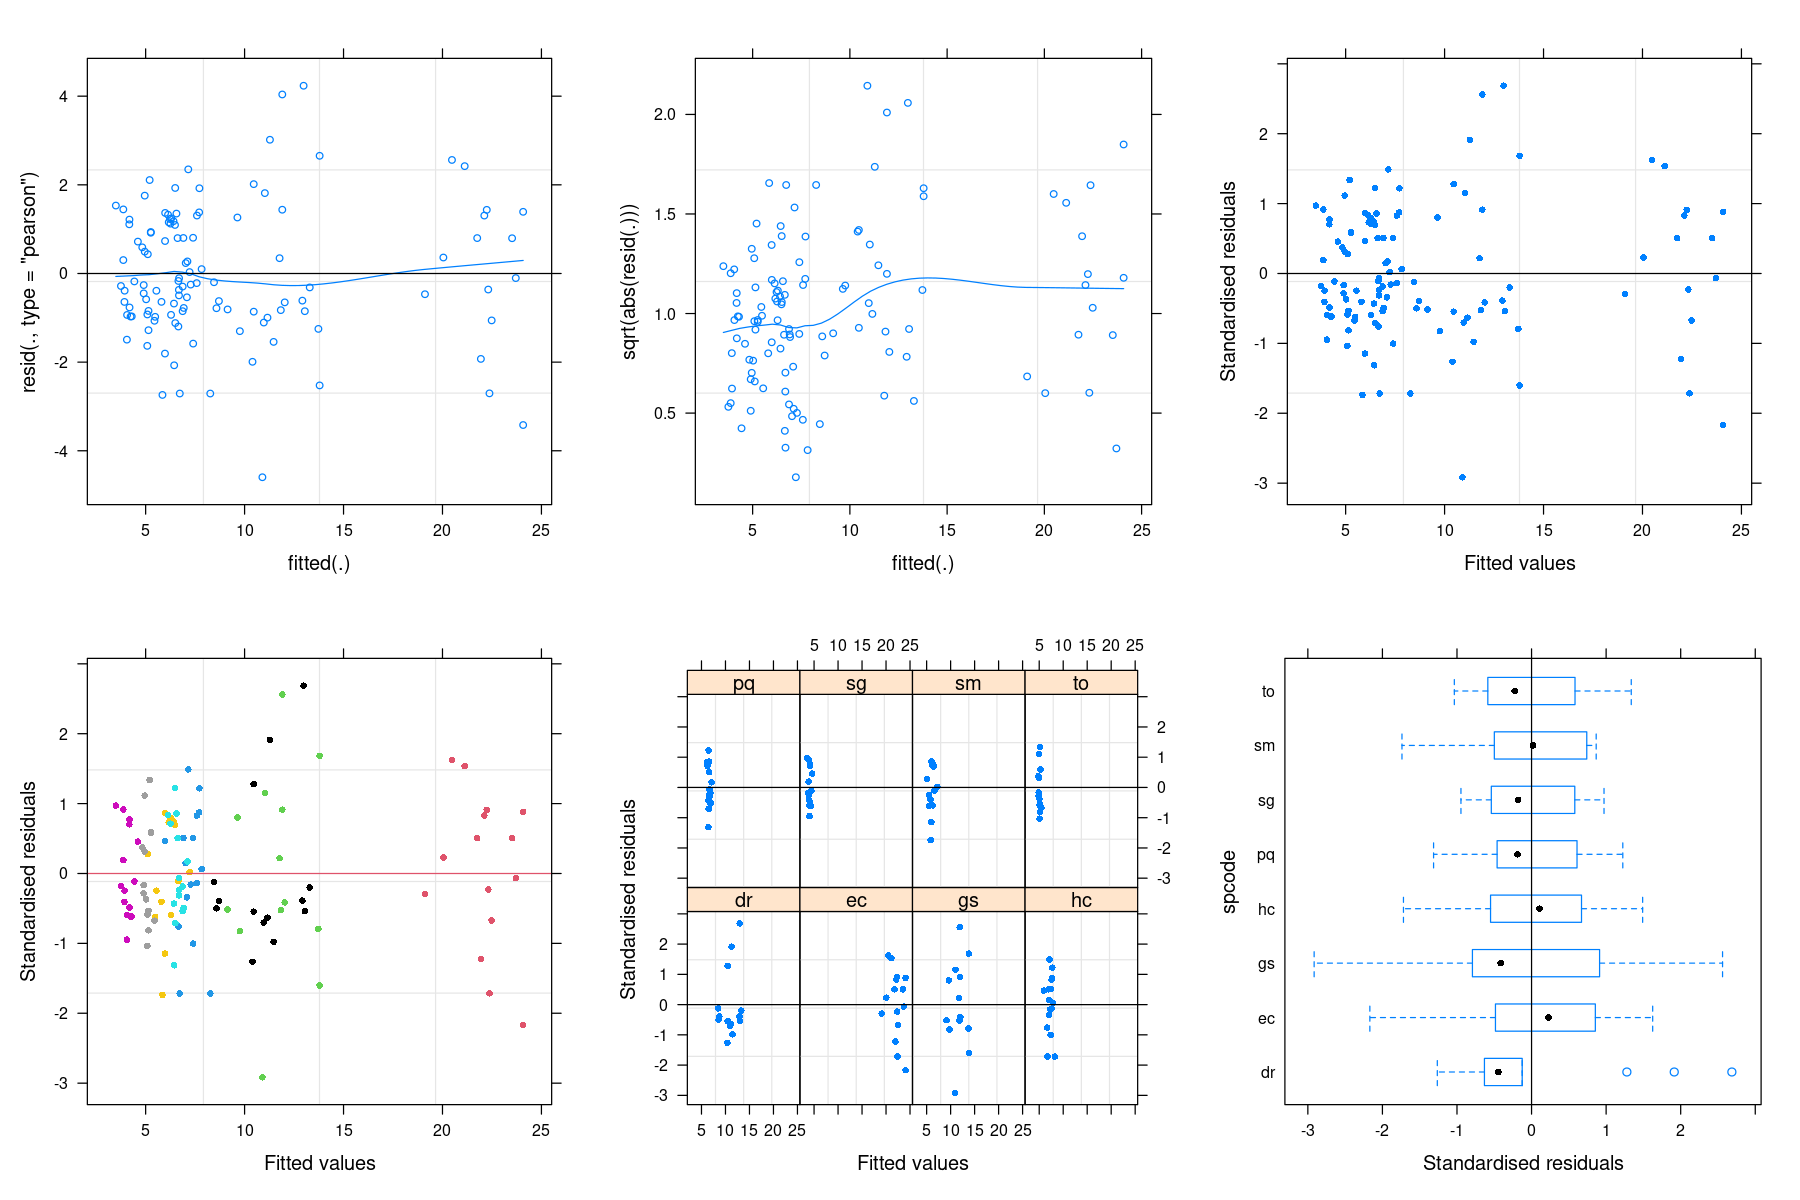

In [14]:
par(mfrow = c(3,3))
validation_plots(models_q2$amax, data = data_for_models,group = "spcode")

### Stomatal Conductance

[1] "No variable specified inthe variables argument"


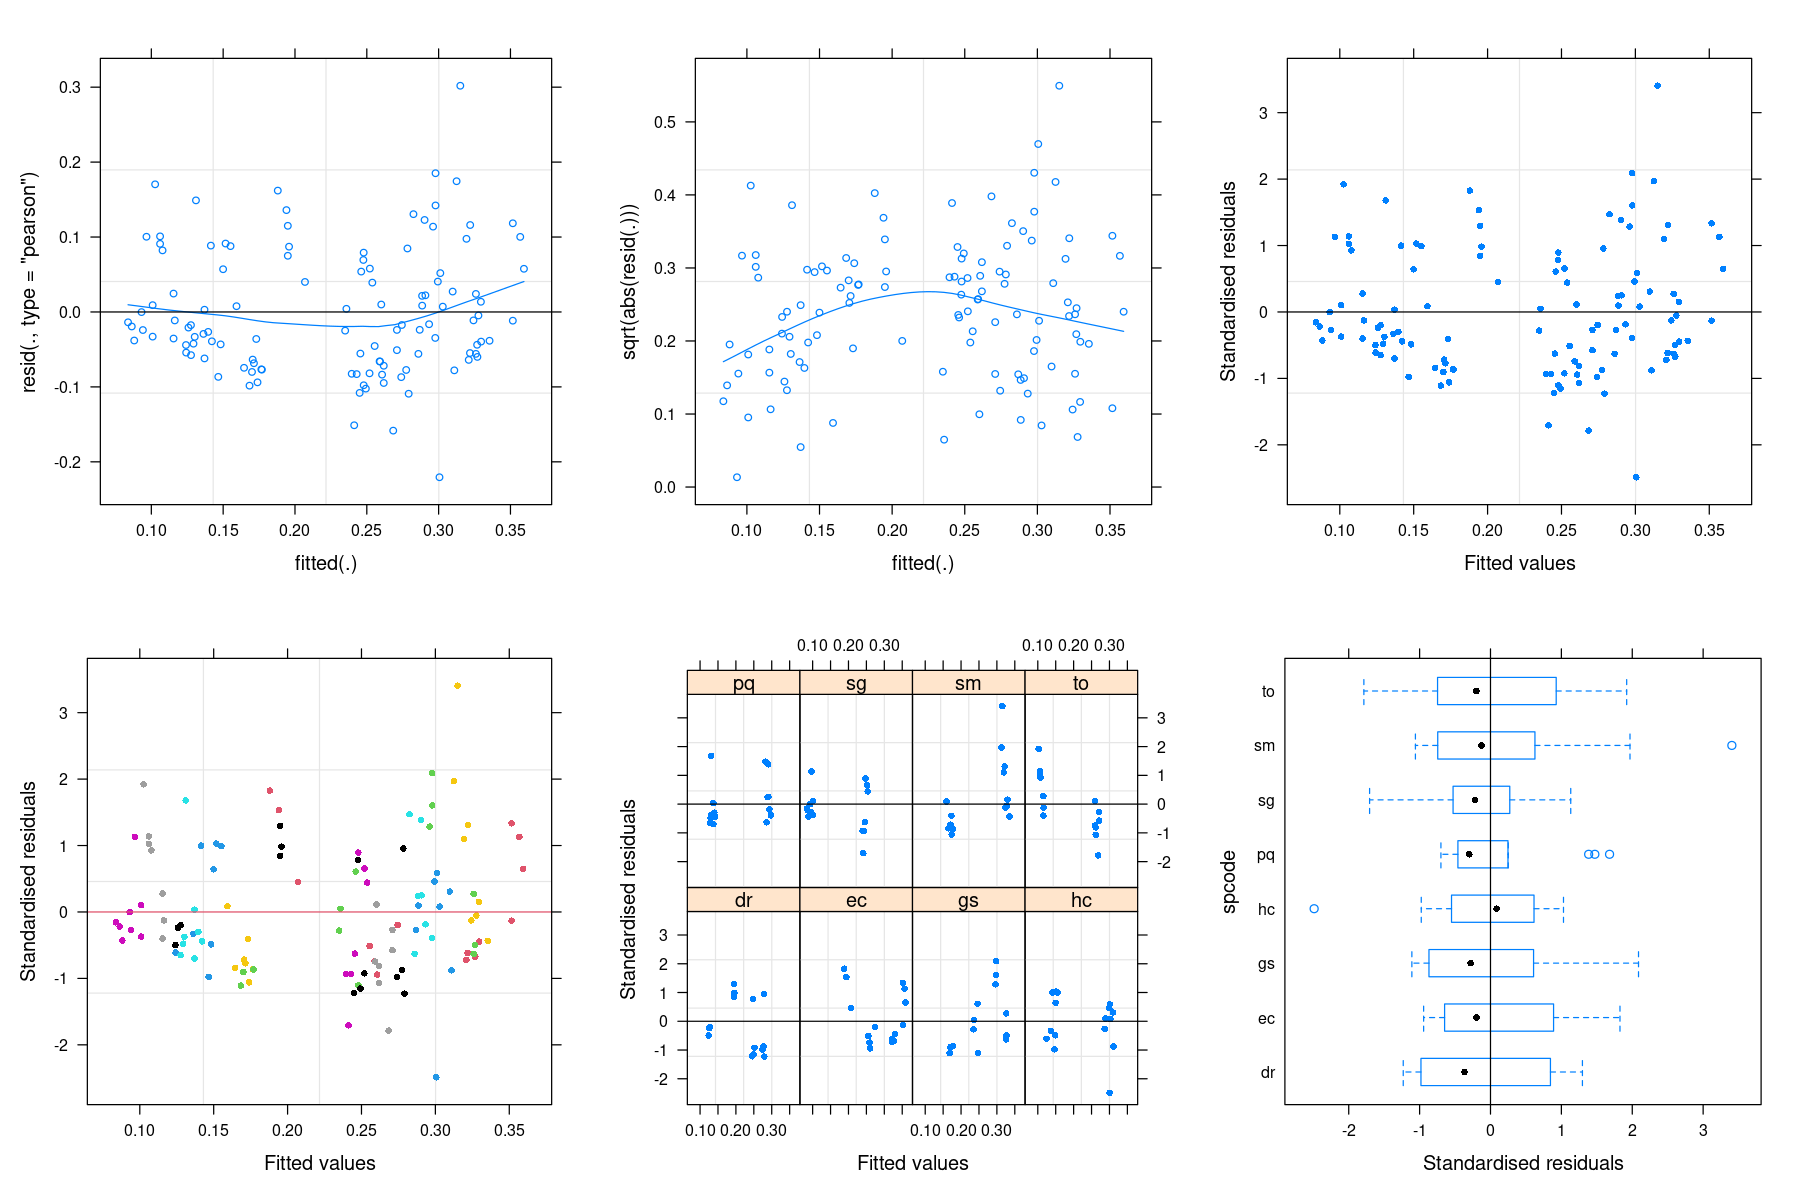

In [15]:
par(mfrow = c(3,3))
validation_plots(models_q2$gs, data = data_for_models,group = "spcode")

### Water Use Efficiency 

[1] "No variable specified inthe variables argument"


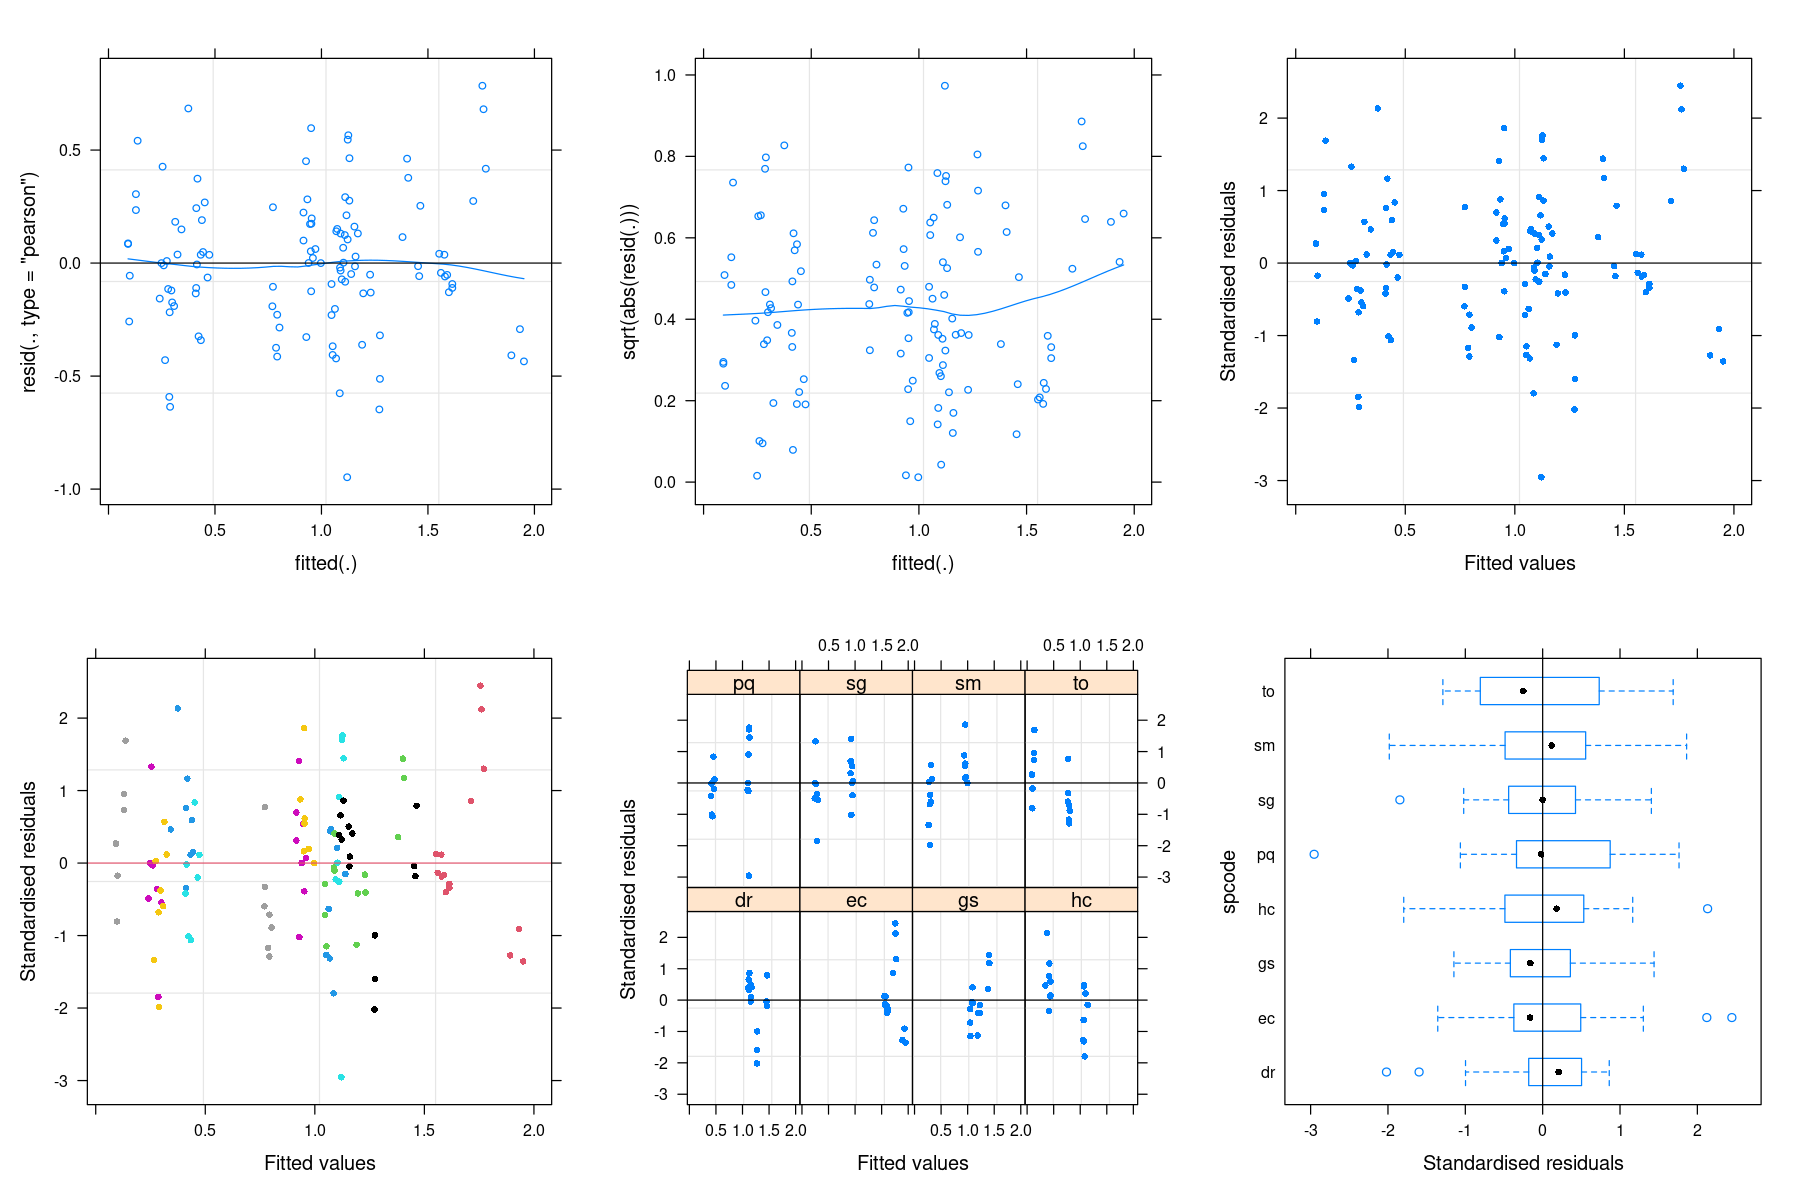

In [16]:
par(mfrow = c(3,3))
validation_plots(models_q2$wue_log, data = data_for_models,group = "spcode")

### Delta 13C

[1] "No variable specified inthe variables argument"


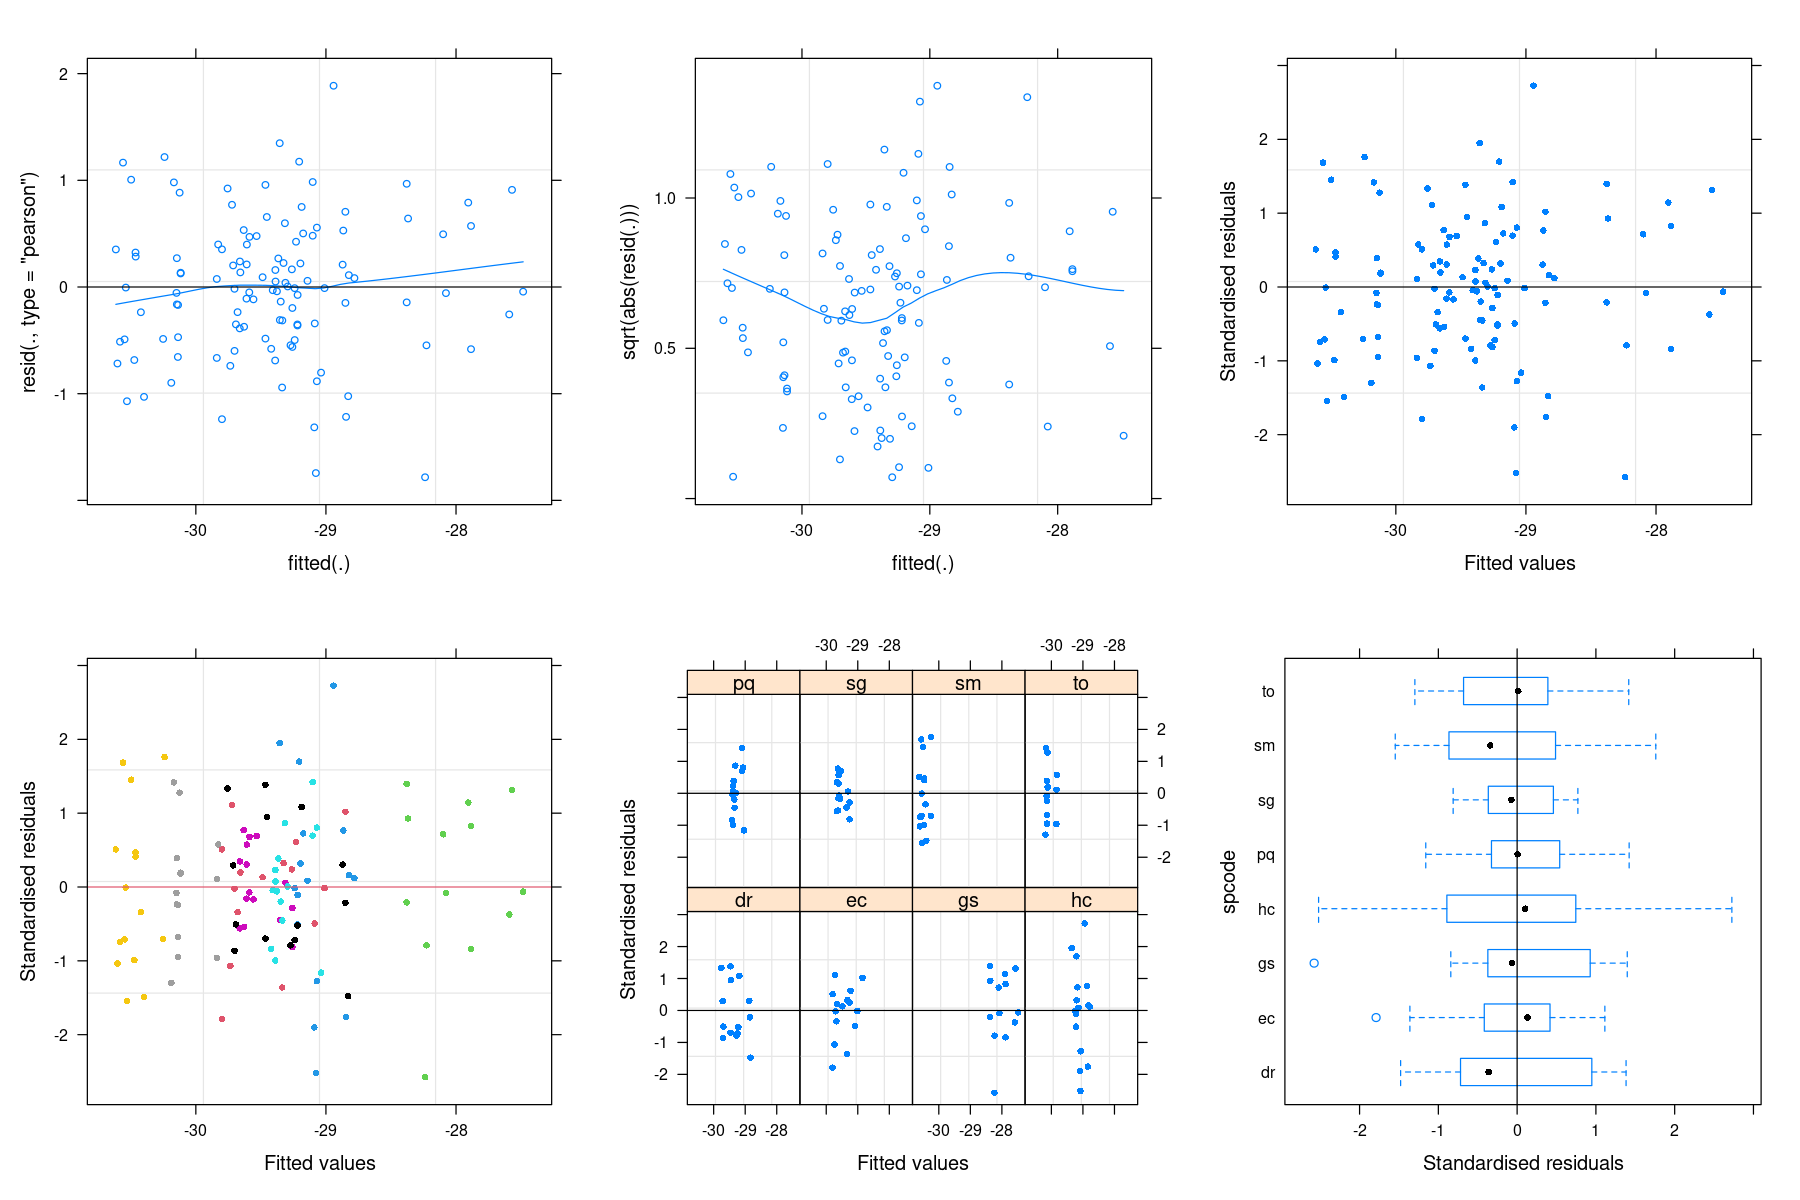

In [17]:
par(mfrow = c(3,3))
validation_plots(models_q2$d13c, data = data_for_models,group = "spcode")

### Specific leaf area

[1] "No variable specified inthe variables argument"


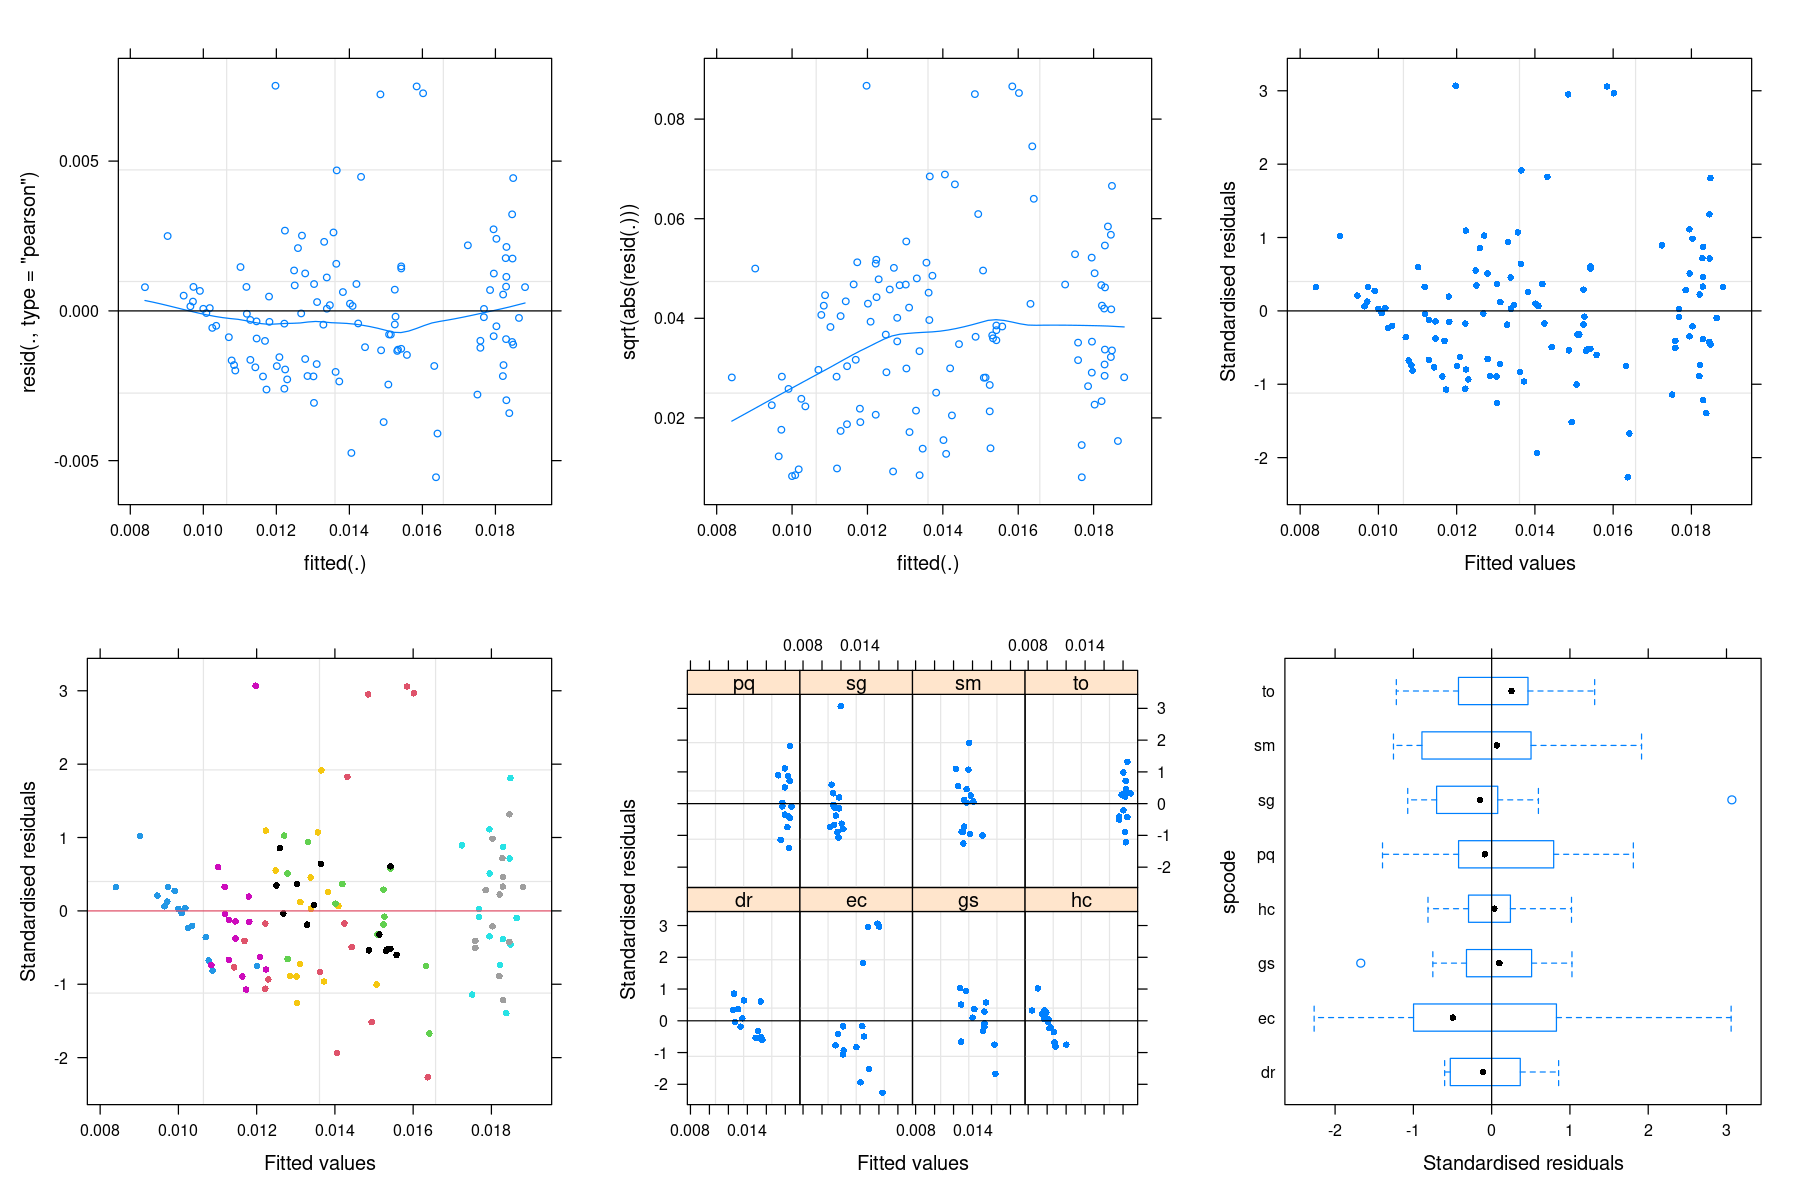

In [18]:
par(mfrow = c(3,3))
validation_plots(models_q2$sla, data = data_for_models,group = "spcode")

### Nitrogen concentration per unit of area

[1] "No variable specified inthe variables argument"


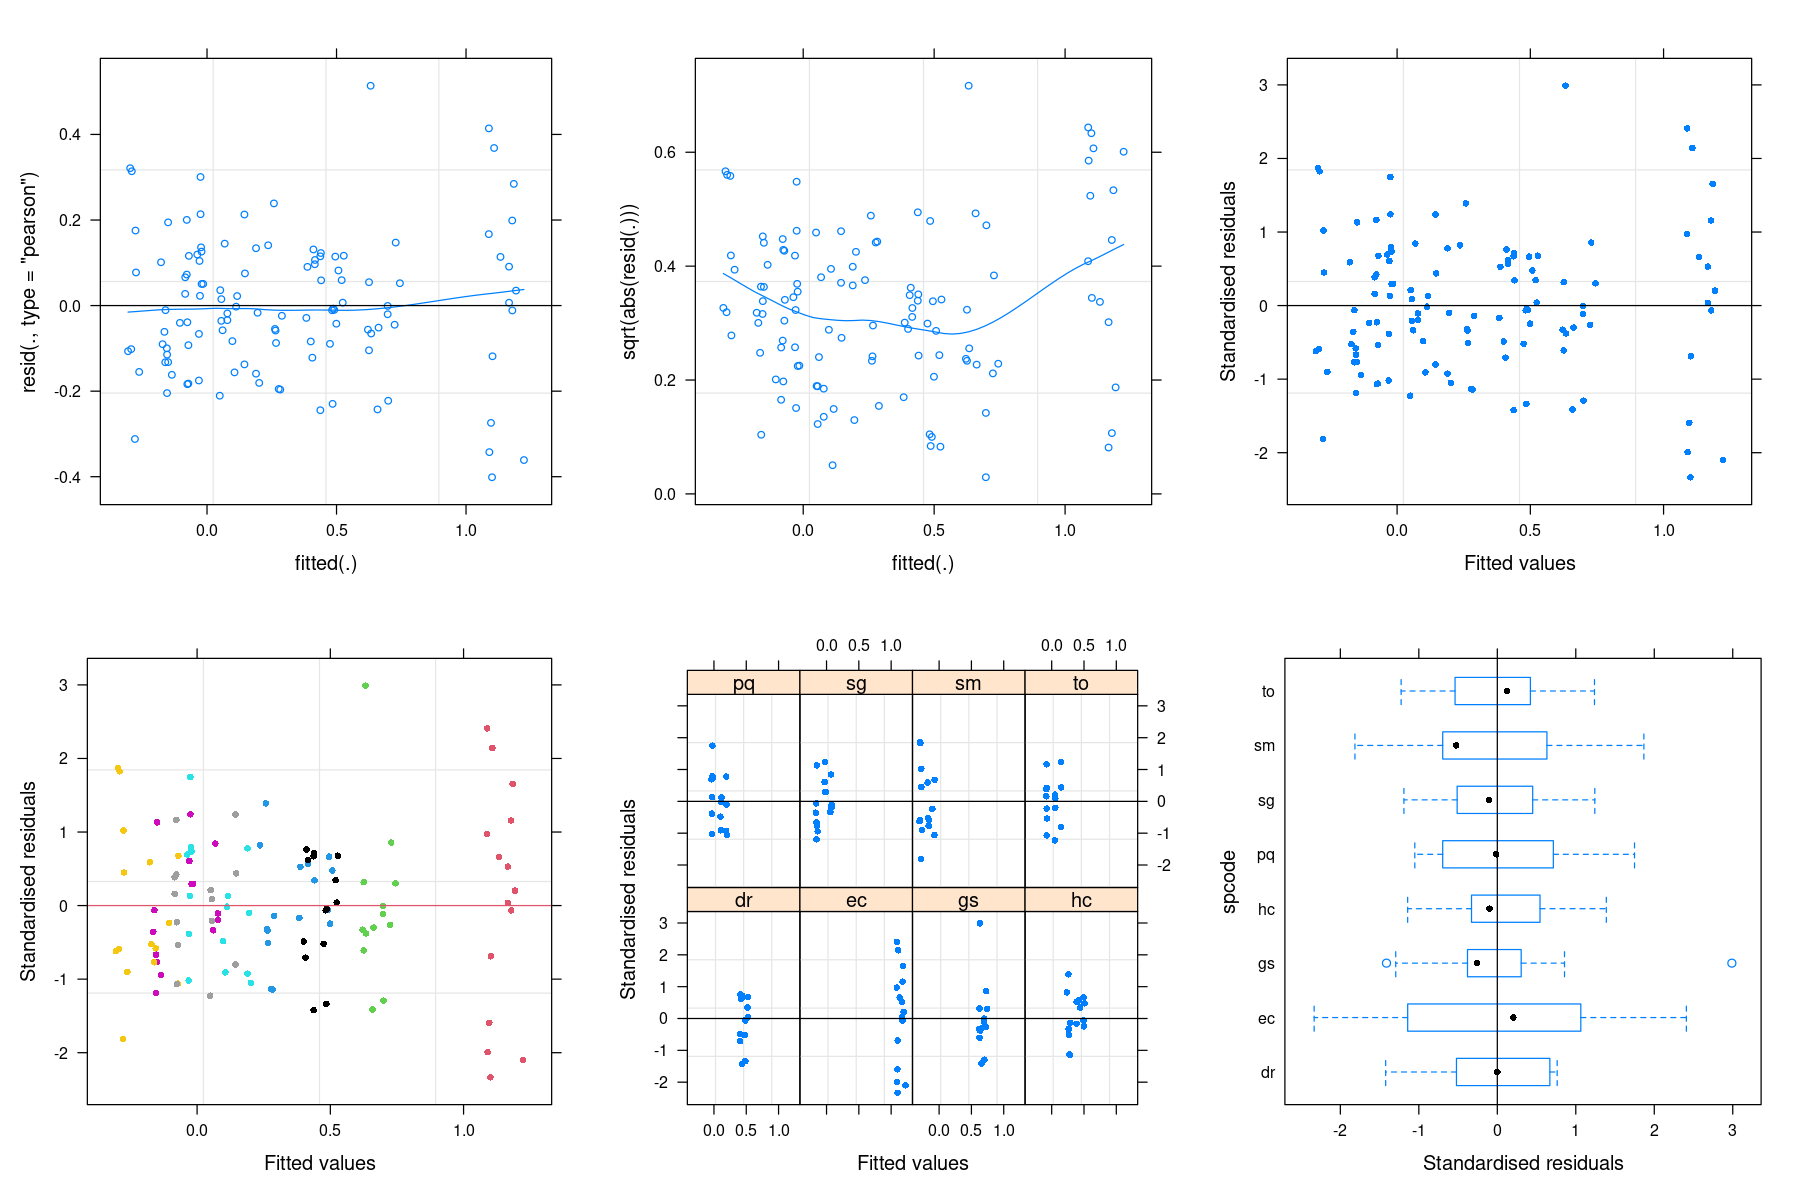

In [19]:
par(mfrow = c(3,3))
validation_plots(models_q2$n_area_log, data = data_for_models,group = "spcode")

### Photosyntetic Nitrogen use efficiency

[1] "No variable specified inthe variables argument"


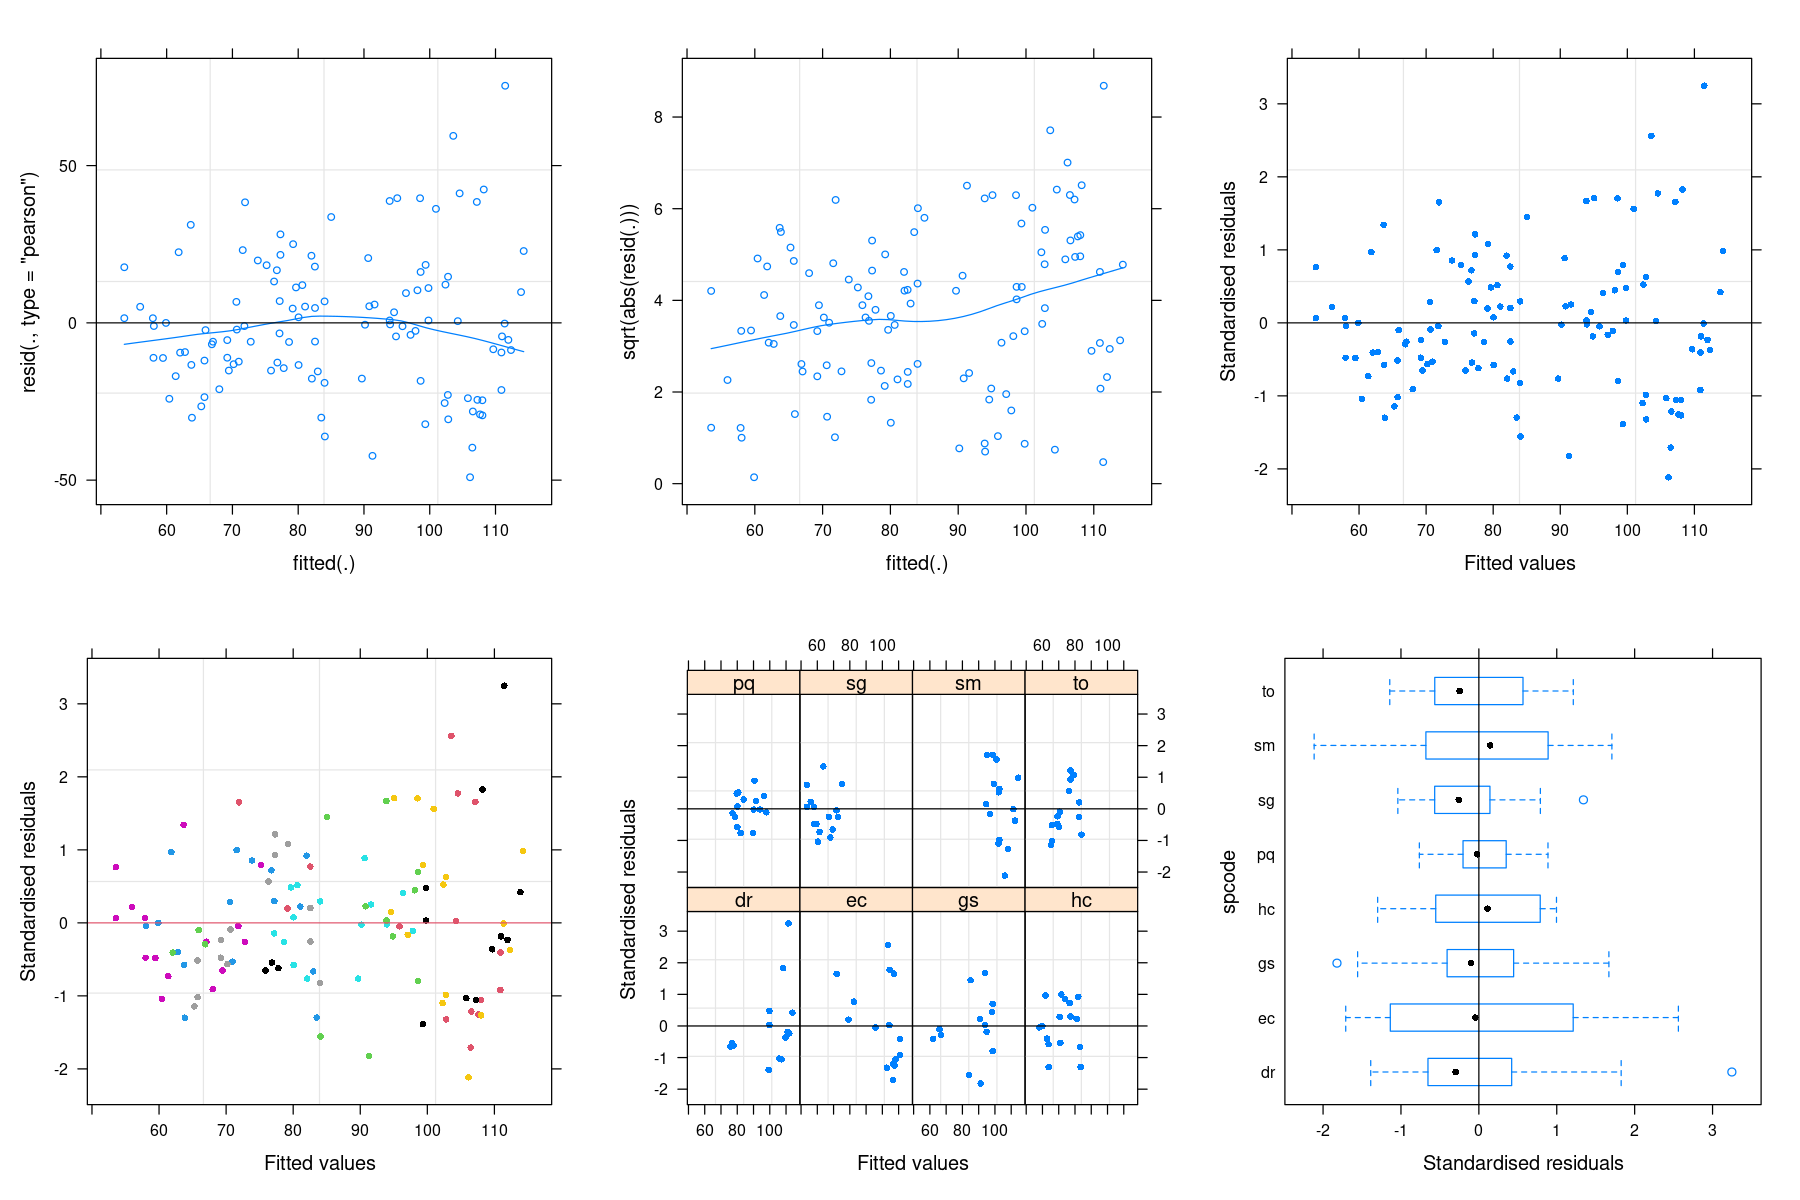

In [20]:
par(mfrow = c(3,3))
validation_plots(models_q2$pnue, data = data_for_models,group = "spcode")

### Nodule count

Zuur et al pp 84:

"Note that these residuals still show heterogeneity, but this is now allowed
(because the residual variation differs depending on the chosen variance
structure and values of the variance covariate). Hence, these residuals are
less useful for the model validation process."

[1] "No variable specified inthe variables argument"


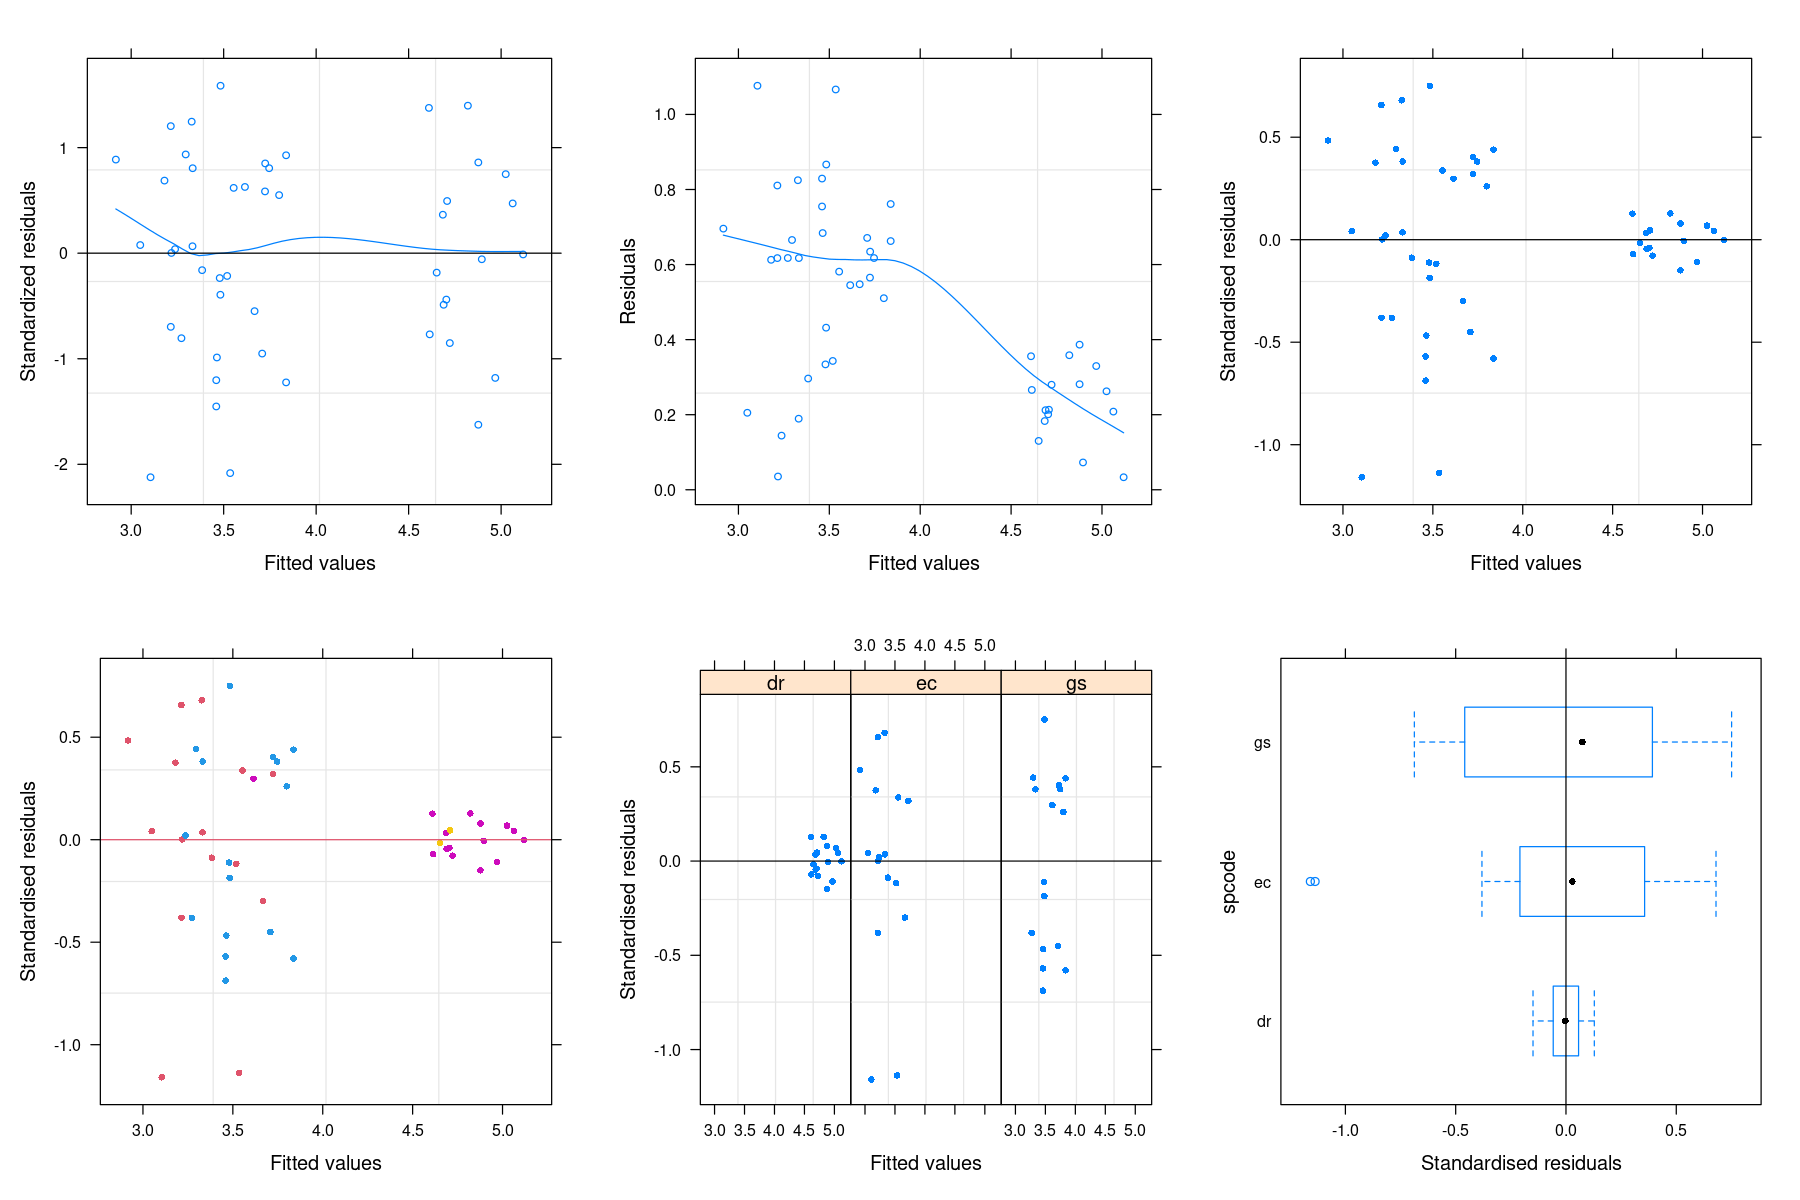

In [21]:
par(mfrow = c(3,3))
validation_plots(models_q2$nodule_log, data = data_for_models,group = "spcode")

## Model inference

### Anova tables

In [37]:
map(models_q2, ~Anova(.x, type = "III", test.statistic = c("F")))

$nodule_log
Analysis of Deviance Table (Type III tests)

Response: log(number_of_root_nodulation)
              Chisq Df Pr(>Chisq)    
(Intercept) 27.5271  1  1.549e-07 ***
treatment   33.9910  3  1.990e-07 ***
init_height  5.3594  1    0.02061 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

$wue_log
Analysis of Deviance Table (Type III Wald F tests with Kenward-Roger df)

Response: log(wue)
                       F Df  Df.res    Pr(>F)    
(Intercept)      33.4628  1  13.769 5.050e-05 ***
nfixer            4.0850  1   9.061  0.073774 .  
treatment        26.8453  3 102.585 6.753e-13 ***
init_height       0.3386  1  28.234  0.565258    
nfixer:treatment  4.6623  3 102.433  0.004275 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

$n_area_log
Analysis of Deviance Table (Type III Wald F tests with Kenward-Roger df)

Response: log(Narea_g_m2)
                       F Df  Df.res    Pr(>F)    
(Intercept)       0.5883  1  11.181 0.4589603    
nfixer           15.9628  1   6.753 0.0056182 ** 
treatment         7.3650  3 102.260 0.0001618 ***
init_height       0.5198  1  84.673 0.4728932    
nfixer:treatment  2.3843  3 102.167 0.0736043 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

$amax
Analysis of Deviance Table (Type III Wald F tests with Kenward-Roger df)

Response: amax
                       F Df  Df.res    Pr(>F)    
(Intercept)      12.3075  1   7.859 0.0082101 ** 
treatment         0.2570  3 102.089 0.8561844    
nfixer            7.9692  1   6.202 0.0291755 *  
init_height       5.3512  1 107.997 0.0226019 *  
treatment:nfixer  7.3837  3 102.053 0.0001585 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

$gs
Analysis of Deviance Table (Type III Wald F tests with Kenward-Roger df)

Response: gs
                       F Df  Df.res    Pr(>F)    
(Intercept)       8.1567  1  13.303   0.01324 *  
treatment        18.6434  3 102.924 9.827e-10 ***
nfixer            6.3961  1  18.189   0.02089 *  
init_height       0.8571  1  10.438   0.37547    
treatment:nfixer  1.6952  3 102.823   0.17270    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

$pnue
Analysis of Deviance Table (Type III Wald F tests with Kenward-Roger df)

Response: pnue
                       F Df  Df.res    Pr(>F)    
(Intercept)      55.0023  1  13.762 3.621e-06 ***
treatment         2.0970  3 102.605    0.1052    
nfixer            0.9818  1   9.319    0.3468    
init_height       2.1500  1  26.298    0.1544    
treatment:nfixer  1.4822  3 102.453    0.2238    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

$d13c
Analysis of Deviance Table (Type III Wald F tests with Kenward-Roger df)

Response: d13c
                         F Df  Df.res Pr(>F)    
(Intercept)      4480.3912  1  13.391 <2e-16 ***
treatment           0.9486  3 102.453 0.4201    
nfixer              1.3720  1   7.817 0.2759    
init_height         1.0058  1  44.979 0.3213    
treatment:nfixer    0.7592  3 102.315 0.5196    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

$sla
Analysis of Deviance Table (Type III Wald F tests with Kenward-Roger df)

Response: sla
                        F Df  Df.res    Pr(>F)    
(Intercept)      111.1196  1  13.316 7.778e-08 ***
treatment          0.2492  3 102.441   0.86176    
nfixer             0.4345  1   7.732   0.52893    
init_height        5.4331  1  46.890   0.02411 *  
treatment:nfixer   1.7986  3 102.305   0.15215    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

### Post-Hoc: Tukey's test

#### Models with significant interaction 

##### Maximal photosynthesis

In [38]:
as_tibble(emmeans(models_q2$amax,
        pairwise ~ treatment*nfixer,
        adjust = "tukey"
        )$contrast) %>%
        mutate(across(2:6, round, 6))

contrast,estimate,SE,df,t.ratio,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no_additions nonfixer - plus_nutrients nonfixer,-0.128657,0.515765,102.144768,-0.249448,0.999997
no_additions nonfixer - plus_water nonfixer,-0.431035,0.520791,102.004653,-0.827655,0.991131
no_additions nonfixer - plus_water_nutrients nonfixer,-0.071649,0.498836,102.014215,-0.143633,1.000000
no_additions nonfixer - no_additions fixer,-9.088761,3.219559,6.201600,-2.822983,0.238193
no_additions nonfixer - plus_nutrients fixer,-7.019938,3.226719,6.257198,-2.175565,0.461776
no_additions nonfixer - plus_water fixer,-11.422974,3.220218,6.206143,-3.547267,0.108377
no_additions nonfixer - plus_water_nutrients fixer,-9.783426,3.222881,6.224767,-3.035615,0.188810
plus_nutrients nonfixer - plus_water nonfixer,-0.302379,0.538011,102.126656,-0.562031,0.999222
plus_nutrients nonfixer - plus_water_nutrients nonfixer,0.057007,0.517720,102.230398,0.110112,1.000000


##### Water Use Efficiency

In [39]:
as_tibble(emmeans(models_q2$wue_log,
        pairwise ~ treatment*nfixer,
        adjust = "tukey"
        )$contrast) %>%
        mutate(across(2:6, round, 6))

contrast,estimate,SE,df,t.ratio,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no_additions nonfixer - plus_nutrients nonfixer,0.022672,0.104732,102.853047,0.216478,0.999999
no_additions nonfixer - plus_water nonfixer,0.658058,0.105942,102.180123,6.211482,0.000000
no_additions nonfixer - plus_water_nutrients nonfixer,0.694960,0.101462,102.212724,6.849442,0.000000
no_additions nonfixer - no_additions fixer,-0.434992,0.215220,9.060734,-2.021147,0.516685
no_additions nonfixer - plus_nutrients fixer,-0.611355,0.219685,9.843645,-2.782872,0.203026
no_additions nonfixer - plus_water fixer,-0.309838,0.215497,9.072601,-1.437787,0.820654
no_additions nonfixer - plus_water_nutrients fixer,-0.277940,0.216668,9.146245,-1.282789,0.884976
plus_nutrients nonfixer - plus_water nonfixer,0.635386,0.109279,102.801769,5.814347,0.000002
plus_nutrients nonfixer - plus_water_nutrients nonfixer,0.672288,0.105012,103.243319,6.402003,0.000000


#### Models with significant nfixer term 

##### Nitrogen concentration per unit of area

In [40]:
as_tibble(emmeans(models_q2$n_area_log,
        pairwise ~ nfixer,
        adjust = "tukey"
        )$contrast) %>%
        mutate(across(2:6, round, 6))

NOTE: Results may be misleading due to involvement in interactions



contrast,estimate,SE,df,t.ratio,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
nonfixer - fixer,-0.721388,0.186654,5.715075,-3.864845,0.009136


##### Stomatal Conductance

In [41]:
as_tibble(emmeans(models_q2$gs,
        pairwise ~ nfixer,
        adjust = "tukey"
        )$contrast) %>%
        mutate(across(2:6, round, 6))

NOTE: Results may be misleading due to involvement in interactions



contrast,estimate,SE,df,t.ratio,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
nonfixer - fixer,-0.041181,0.029986,5.169261,-1.373361,0.226216


#### Models with significant treatment term  

##### Nitrogen concentration per unit of area

In [42]:
as_tibble(emmeans(models_q2$n_area_log,
        pairwise ~ treatment,
        adjust = "tukey"
        )$contrast) %>%
        mutate(across(2:6, round, 6))


NOTE: Results may be misleading due to involvement in interactions



contrast,estimate,SE,df,t.ratio,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no_additions - plus_nutrients,-0.157499,0.048013,102.4137,-3.280355,0.007625
no_additions - plus_water,-0.023590,0.046497,102.1019,-0.507341,0.957172
no_additions - plus_water_nutrients,-0.050217,0.046137,102.6597,-1.088412,0.697388
plus_nutrients - plus_water,0.133910,0.048950,102.6682,2.735641,0.036320
plus_nutrients - plus_water_nutrients,0.107283,0.049064,103.7318,2.186593,0.133776
plus_water - plus_water_nutrients,-0.026627,0.046558,102.3557,-0.571905,0.940237


##### Stomatal Conductance

In [43]:
as_tibble(emmeans(models_q2$gs,
        pairwise ~ treatment,
        adjust = "tukey"
        )$contrast) %>%
        mutate(across(2:6, round, 6))

NOTE: Results may be misleading due to involvement in interactions



contrast,estimate,SE,df,t.ratio,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no_additions - plus_nutrients,0.028169,0.024675,103.1872,1.141632,0.664720
no_additions - plus_water,-0.124503,0.023967,102.8730,-5.194720,0.000006
no_additions - plus_water_nutrients,-0.104146,0.023656,103.6711,-4.402501,0.000152
plus_nutrients - plus_water,-0.152673,0.025095,103.6233,-6.083662,0.000000
plus_nutrients - plus_water_nutrients,-0.132315,0.024881,105.1614,-5.318026,0.000004
plus_water - plus_water_nutrients,0.020357,0.023939,102.9949,0.850390,0.830145


##### Nodule Count

In [44]:
as_tibble(emmeans(models_q2$nodule_log,
        pairwise ~ treatment,
        adjust = "tukey"
        )$contrast) %>%
        mutate(across(2:6, round, 6))

contrast,estimate,SE,df,t.ratio,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ambientrain - ambientrain_nutrients,0.168648,0.064247,41,2.624984,0.056480
ambientrain - ambientrain_water,0.116467,0.068880,41,1.690864,0.341466
ambientrain - ambientrain_water_nutrients,-0.185805,0.062976,41,-2.950424,0.025831
ambientrain_nutrients - ambientrain_water,-0.052181,0.064750,41,-0.805885,0.851284
ambientrain_nutrients - ambientrain_water_nutrients,-0.354452,0.063957,41,-5.542023,0.000011
ambientrain_water - ambientrain_water_nutrients,-0.302272,0.068268,41,-4.427689,0.000389


### Treatment effects

## Plots 